# Projeto Final da Disciplina Mineração de Textos e Web Ministrada pelo Prof. Luciano Barbosa

**Equipe:**
<br>David Soares do Monte
<br>Wanderson Rodrigues Marques


# Etapa 1: Dataset

## Informações sobre o dataset
O dataset é composto orinalmente por 5890 avaliações obtidas no site da Amazon Brasil referentes ao produto "Suporte para Notebook, OCTOO, Uptable, UP-BL, Preto" (https://www.amazon.com.br/OCTOO-UP-BL-Suporte-Uptable-Preto/dp/B07BTC67VS/ref=zg-bs_furniture_1/144-8354270-3806822).

## Importação das Bibliotecas Necessárias

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Importação e Pré-processamento do Dataset

In [ ]:
# Função para o 'date_parser' para converter a data no momento de leitura do dataset através do 'pd.read_csv'

def date_converter(date):
    month = 0
    month_list = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 
                  'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
    
    date_sep = date.split(' ') # Ex.: '24 de setembro de 2019' => ['24', 'de', 'setembro', 'de', '2019']
    
    for i, m in enumerate(month_list): # Verifica a terceira posição da lista para fazer a conversão do mês
        if date_sep[2] == m:
            month = i + 1
            break
    
    year = int(date_sep[4]) # Última posição da lista 'date_sep'
    day = int(date_sep[0])  # Primeira posição da lista 'date_sep'
            
    date_conv = dt.date(year=year, month=month, day=day) # Compõe a data que será retornada
    
    return date_conv

In [ ]:
# Importa o dataset

df1 = pd.read_csv('av_positivo_projeto_NLP_4560.csv', decimal=',', parse_dates=[2], 
                 date_parser=date_converter, usecols=['reviews', 'star', 'date'])
df2 = pd.read_csv('av_critico_projeto_NLP_1330.csv', decimal=',', parse_dates=[2], 
                 date_parser=date_converter, usecols=['reviews', 'star', 'date'])
df = pd.concat([df1, df2])
df.reset_index(drop=True, inplace=True)

In [ ]:
# Imprime 5 amostras do dataset

df.sample(5)

,reviews,star,date
2783,O produto é leve e cumpre a funcionalodade com...,5.0,2021-08-29
5330,O produto veio com uma das pernas molenga. Mor...,1.0,2021-03-14
5378,Gostaria de dizer que um dos produtos veio que...,1.0,2021-06-03
160,"Um dos encaixes não funciona, de modo que a ""p...",5.0,2021-09-16
4497,Entrega no prazo e produto ótimo!!,5.0,2021-04-15


In [ ]:
# Imprime formato do dataset

print('Shape do dataset:', df.shape)

Shape do dataset: (5890, 3)


In [ ]:
# Deste ponto em diante será utilizado o dataset 'df_reviews'

# Ordena o dataset pela data, cria uma cópia (df_reviews) e faz o reset dos índices

df_reviews = df.sort_values(by=['date']).copy()
df_reviews.reset_index(drop=True, inplace=True)

# Adiciona a coluna 'sentiment' baseado no critério: positivo se star > 3 e negativo caso contrário

df_reviews['sentiment'] = df_reviews['star'].apply(lambda v: 'positive' if v > 3 else 'negative')

# Reordena as colunas do dataset

df_reviews = df_reviews[['date', 'reviews', 'star', 'sentiment']]

# Redefine os tipos dos dados

df_reviews['reviews'] = df_reviews['reviews'].astype('category')
df_reviews['star'] = df_reviews['star'].astype('int8')
df_reviews['star'] = df_reviews['star'].astype('category')
df_reviews['sentiment'] = df_reviews['sentiment'].astype('category')

In [ ]:
df_reviews.head()

,date,reviews,star,sentiment
0,2019-04-07,"Leve, simples, ocupa pouco espaço.",5,positive
1,2019-09-24,"Produto de boa qualidade, tanto pela aparência...",4,positive
2,2019-10-10,"Duro, pequeno e não tão resistente. Já desinca...",2,negative
3,2019-10-31,"Fácil de montar e desmontar, pode ser posicion...",5,positive
4,2019-12-02,"Prático, leve e resistente",5,positive


In [ ]:
# Intervalo de datas no qual foram capturadas os reviews

print('Período das reviews: ', df_reviews['date'].min().strftime('%Y-%m-%d'), 'a',\
      df_reviews['date'].max().strftime('%Y-%m-%d'))

Período das reviews:  2019-04-07 a 2022-03-22


In [ ]:
# Verificação de dados ausentes

(df_reviews.isna().sum())

date          0
reviews      59
star          0
sentiment     0
dtype: int64

In [ ]:
# Remove instâncias com reviews vazias

df_reviews.dropna(axis=0, how='any', inplace=True, subset=['reviews'])
df_reviews.reset_index(drop=True, inplace=True)
df_reviews.shape

(5831, 4)

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5831 non-null   datetime64[ns]
 1   reviews    5831 non-null   category      
 2   star       5831 non-null   category      
 3   sentiment  5831 non-null   category      
dtypes: category(3), datetime64[ns](1)
memory usage: 240.1 KB


In [ ]:
# Descrição das variáveis categóricas

df_reviews.describe(include='category')

,reviews,star,sentiment
count,5831,5831,5831
unique,5413,5,2
top,Muito bom,5,positive
freq,64,3552,4520


In [ ]:
# Verificação do balaceamento das classes - coluna 'sentiment'

per_var = pd.DataFrame()
per_var['count'] = df_reviews['sentiment'].value_counts()
per_var['%'] = per_var['count']/len(df_reviews['sentiment'])*100
per_var

,count,%
positive,4520,77.516721
negative,1311,22.483279


# Etapa 2: Processamento dos Dados Textuais

## Importação das Bibliotecas Necessárias

In [ ]:
#from collections import Counter
from collections import Counter
import string
import nltk
#import spacy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('punkt') # A data model created by Jan Strunk that NLTK uses to split full texts into word lists

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsm3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dsm3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Tokenização das Sentenças

In [ ]:
# !pip install gensim==4.1.2

In [ ]:
import gensim
import gensim.downloader
gensim.__version__

'4.1.2'

In [ ]:
from gensim.models import KeyedVectors #, Word2Vec 

### Com Stemming

* word2vec pré-treinado em português:
<br>http://www.nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [ ]:
word2vc_vectors = KeyedVectors.load_word2vec_format('cbow_s100.txt')

In [ ]:
# Tokenização
sentences_set_amz = []
sentence = []
dict_pt = {}
punct_set = list(string.punctuation) + ['..', '...', "''", "'''", '``', '```', '*', '**', '***', '…', '^', '^^', '-']
stop_words = set(stopwords.words('portuguese'))

for item in df_reviews['reviews']:
  words = word_tokenize(item, language='portuguese')
  for token in words:
    token = token.lower()                                        # Todas as palavras em minúsculo
    if token not in punct_set and token not in stop_words: # and not token[0].isdigit():       # Verifica se não é pontuação ou 'stop word'
      while (len(token) > 0 and token[0] in punct_set):          # Removendo pontuação do início das palavras
        token = token[1:]
      while (len(token) > 0 and token[-1] in punct_set):         # Removendo pontuação do fim das palavras
        token = token[:-1]
      token = stemmer.stem(token)
      if len(token) > 1 and token in word2vc_vectors.key_to_index:
        sentence.append(token) 
  sentences_set_amz.append(sentence)

  word_freq = Counter(sentence)

  for word,freq in word_freq.items():
    if word in dict_pt.keys():
      dict_pt[word] = dict_pt[word] + freq
    else:
      dict_pt[word] = freq
  sentence = []

sentences_set = np.asarray(sentences_set_amz, dtype='object')

print('Nº de sentenças:', len(sentences_set))
print("Tamanho do vocabulário: ", len(dict_pt))
print("Vocabulário:\n", sorted(dict_pt.keys()))

Nº de sentenças: 5831
Tamanho do vocabulário:  3933
Vocabulário:
 ['aba', 'abafado', 'abaixa', 'abaixar', 'abaixo', 'aberta', 'aberto', 'abertura', 'abr', 'abraçar', 'abraço', 'abri', 'abrindo', 'abrir', 'abriu', 'abro', 'abrupta', 'absurda', 'absurdo', 'acab', 'acaba', 'acabada', 'acabado', 'acabam', 'acabamento', 'acabando', 'acabar', 'acabaram', 'acabei', 'acabo', 'aceita', 'aceitam', 'aceitável', 'acer', 'acerca', 'acert', 'acerta', 'acertando', 'acertar', 'acertava', 'acertei', 'acertá-lo', 'acessível', 'acessório', 'acha', 'achado', 'achando', 'achar', 'achava', 'achei', 'achei-o', 'achem', 'acho', 'achou', 'acima', 'acionei', 'acomoda', 'acomodado', 'acomodar', 'acompanha', 'acompanhado', 'acompanham', 'acompanhamento', 'acompanhar', 'acondiciona', 'acondicionada', 'aconselharia', 'aconselho', 'aconselhável', 'aconteceu', 'aconteça', 'aconteçam', 'acoplamento', 'acoplar', 'acordo', 'acostumado', 'acostumando', 'acostumar', 'acostumei', 'acredito', 'acrescentar', 'acumula', 'acus

In [ ]:
dict_pt_df = pd.DataFrame(sorted(list(dict_pt.items()), key=lambda v: v[1], reverse=True), columns=['words', 'freq'])
dict_pt_df.head(10)

,words,freq
0,produto,2104
1,notebook,1516
2,bem,1328
3,bom,1286
4,suport,1087
5,fica,832
6,fácil,687
7,pouco,623
8,torto,584
9,veio,577


In [ ]:
#dict_pt_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Colabs - NLP/NLP Projeto Final/dicionario.csv')

In [ ]:
# Verifica se há alguma sentença vazia e remove do conjunto de sentenças e do dataset
null_sentences = []

for i,sentence in enumerate(sentences_set):
  if len(sentence) == 0:
    null_sentences.append(i)
    #print(sentence)
print(null_sentences)

sentences_set = np.delete(sentences_set, null_sentences)

# Atualiza a base de dados removendo as instâncias correspondentes a sentenças vazias
if len(null_sentences) > 0:
  df_reviews = df_reviews.drop(null_sentences, axis=0)
  df_reviews.reset_index(drop=True, inplace=True)

[40, 160, 344, 418, 429, 469, 496, 700, 711, 949, 1052, 1146, 1434, 1548, 1588, 1654, 1692, 1815, 2070, 2076, 2124, 2215, 2236, 2408, 2415, 2507, 2544, 2583, 2639, 2717, 2874, 2941, 3141, 3214, 3253, 3386, 4150, 4169, 4188, 4217, 4498, 4547, 4591, 4770, 4830, 5286, 5307, 5410, 5447, 5685, 5717, 5774]


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5779 entries, 0 to 5778
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5779 non-null   datetime64[ns]
 1   reviews    5779 non-null   category      
 2   star       5779 non-null   category      
 3   sentiment  5779 non-null   category      
dtypes: category(3), datetime64[ns](1)
memory usage: 239.5 KB


In [ ]:
# Imprime um exemplo de sentença tokenizada
print(sentences_set[0])

['leve', 'simpl', 'ocupa', 'pouco', 'espaço']


# Etapa 3: Implementação dos Classificadores

## Importação de Bibliotecas Necessárias

In [ ]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## Pré-processamento

In [ ]:
# Pré-processamento das classes

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_reviews['sentiment'])

print('Classes numéricas:', np.unique(y))
print('Classes:', list(label_encoder.inverse_transform(np.unique(y))))
print('Nº de elementos de y:', len(y))

Classes numéricas: [0 1]
Classes: ['negative', 'positive']
Nº de elementos de y: 5779


In [ ]:
# Passando as sentenças tokenizadas para o modelo treinado para obter o conjunto de embeddings 'X'

X = []
max_len = 0

for i,sentence in enumerate(sentences_set):
  vector = word2vc_vectors[sentence]        # model_amazon.wv[sentence]  [UNK]
  X.append(vector)
  max_len = max(max_len, len(vector))

print('max_len:', max_len)
print('N° de elementos de X:', len(X))

max_len: 118
N° de elementos de X: 5779


In [ ]:
# Redimensionamento dos vetores 
VECTOR_SIZE = 100

def transform(exemplos, dimension):
  results = np.zeros((len(exemplos), dimension, VECTOR_SIZE))
  for i, sequence in enumerate(exemplos):
    results[i, (dimension - len(sequence)):, :] = sequence
  return results
 
X = transform(X, max_len)

# Normalização de X para intervalo [-1,1]
X_min = X.min()
X_max = X.max()
range_X = X_max - X_min

X = ((X - X_min)/range_X - 0.5) * 2

print('Range após normalização:', [X.min(), X.max()])
print(X.shape)

Range após normalização: [-1.0, 1.0]
(5779, 118, 100)


## Agrupamento para Identificação das Reviews mais Representativas

* Material de referência: 
<br> https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/#generate-document-vectors

* Vetorização e redução das sentenças para um vetor único por meio da média dos vetores

In [ ]:
def mean_vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
          vectors.append(model[token])
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = mean_vectorize(sentences_set, model=word2vc_vectors)

print('Shape do vetor médio gerado para cada reviews após o embedding:', (len(vectorized_docs), len(vectorized_docs[0])))

Shape do vetor médio gerado para cada reviews após o embedding: (5779, 100)


In [ ]:
# Busca do número ótimo de clusters através da análise de silhueta
seed = 1275
SAMPLE_SIZE = 350
silhouette_score_list = []

for k in np.arange(2,21):
  km = KMeans(n_clusters=k, n_init=100, init='k-means++', random_state=seed).fit(vectorized_docs) # MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X_docs)
  silhouette_score_list.append(silhouette_score(vectorized_docs, km.labels_, metric="euclidean", sample_size=350, random_state=seed))

best_score = max(silhouette_score_list)
best_cluster = silhouette_score_list.index(best_score) + 2

print('Melhor silhueta:', best_score)
print('Nº de Clusters:', best_cluster)

Melhor silhueta: 0.35588777
Nº de Clusters: 3


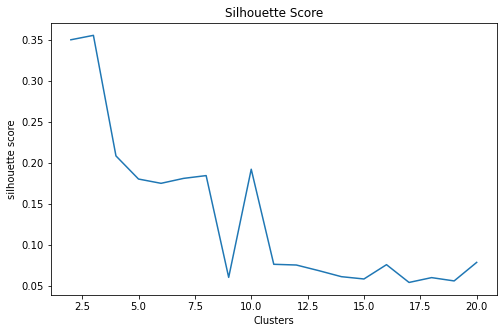

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(np.arange(2,21)), silhouette_score_list)
plt.title('Silhouette Score')
plt.xlabel('Clusters')
plt.ylabel('silhouette score')
plt.show()

In [ ]:
def kmeans_clusters(
    X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = KMeans(n_clusters=k, n_init=100, init='k-means++', random_state=seed).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in np.arange(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [ ]:
clustering, cluster_labels = kmeans_clusters(
    X=vectorized_docs,
    k=best_cluster,
    mb=500,
    print_silhouette_values=True,
)

For n_clusters = 3
Silhouette coefficient: 0.35
Inertia:5309.276295395076
Silhouette values:
    Cluster 0: Size:5175 | Avg:0.36 | Min:0.02 | Max: 0.51
    Cluster 2: Size:432 | Avg:0.29 | Min:-0.05 | Max: 0.56
    Cluster 1: Size:172 | Avg:0.05 | Min:-0.23 | Max: 0.37


* Redução de dimensionalidade com o PCA para visualização dos agrupamentos

In [ ]:
scaler = StandardScaler()
scaled_docs = scaler.fit_transform(vectorized_docs)
pca = PCA(n_components=2)
pca_docs = pca.fit_transform(scaled_docs)
pca_docs.shape

(5779, 2)

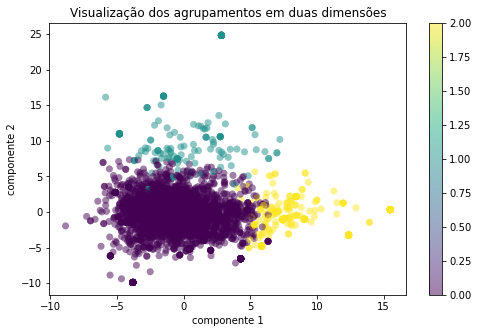

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(pca_docs[:, 0], pca_docs[:, 1], c=cluster_labels, edgecolor='none', alpha=0.5, cmap='viridis', s=50)
plt.title('Visualização dos agrupamentos em duas dimensões')
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.colorbar();

In [ ]:
# Cria um df relacionando: 'sentiment', 'reviews', 'tokens', 'clusters'.
df_clusters = pd.DataFrame({
    "sentiment": df_reviews['sentiment'],
    "reviews": df_reviews['reviews'],
    "tokens": [" ".join(text) for text in sentences_set],
    "cluster": cluster_labels
})

In [ ]:
df_clusters.sample(5)

,sentiment,reviews,tokens,cluster
2601,positive,Prático e fácil de manusear.,prático fácil manusear,0
4413,positive,Excelente! O melhor que já usei!,melhor usei,1
1312,positive,"Facilitou muito a minha vida, porque trablho d...",vida porqu trablho home segundo compro porqu c...,0
1010,positive,"O suporte é resistente,deixa o notebook(no meu...",suport deixa notebook caso bem estável melhor ...,0
1343,negative,Uma das pernas do suporte ficou bamba já nos p...,perna suport ficou bamba primeiro dia uso veze...,0


In [ ]:
# Termos mais representativos baseados nos centroídes

print("Most representative terms per cluster (based on centroids):")

for i in np.arange(best_cluster):
    tokens_per_cluster = ""
    most_representative = word2vc_vectors.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: holodeck bem-passado websítio requebrado copito 
Cluster 1: gostei manjo desisti esqueã§o aprecio 
Cluster 2: bom ótimo perfeito óptimo satisfatório 


numpy.argsort: Returns the indices that would sort an array
<br> https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
<br> numpy.linalg.norm: Matrix or vector norm
<br> https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

In [ ]:
# Documentos mais representativos para um cluster específico
test_cluster = 1

most_representative_docs = np.argsort(np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1))

for d in most_representative_docs[:40]:
    print(df_clusters.iloc[d])
    print("-------------")

sentiment                                             positive
reviews      Cumpre o que promete, é resistente.. gostei ba...
tokens                                           promet gostei
cluster                                                      1
Name: 5736, dtype: object
-------------
sentiment                               positive
reviews      Gostei muito do suporte. Recomendo.
tokens                   gostei suport recomendo
cluster                                        1
Name: 3744, dtype: object
-------------
sentiment                   positive
reviews      Gostei! Muito funcional
tokens                gostei funcion
cluster                            1
Name: 174, dtype: object
-------------
sentiment           positive
reviews      Gostei demais!!
tokens          gostei demai
cluster                    1
Name: 3137, dtype: object
-------------
sentiment                                positive
reviews      Gostei muito do produto e recomendo!
tokens                   gost

## C1: Random Forest

In [ ]:
seed = 1275
X_rfc = np.reshape(X,(X.shape[0], max_len*VECTOR_SIZE))
y_rfc = y

# Divisao da base de dados em treinamento, validacao e teste
X_train, X_test, y_train, y_test = train_test_split(X_rfc, y_rfc, test_size=0.2, stratify=y_rfc, random_state=seed)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, stratify=y_train, random_state=seed)

# Instanciando o modelo
rfc = RandomForestClassifier(random_state=seed)

# K-fold estratificado com k = 10
cv = StratifiedKFold(n_splits=10)

# definição dos parâmetros para a árvore de decisão
param_distributions = { 
                        'n_estimators': [10,11,12,15,16,17,18,19,20],
                        'criterion': ['gini', 'entropy'],
                        'max_depth': [12,14,15,16,17,18,20],
                        'min_samples_split': [15,16,17,18,19,20,21,25],
                        'min_samples_leaf': [4,5,6,7,8,9,10],
                        'max_features':['auto', 'sqrt'] #, 'log2']
                      }

# define random search for decision tree
rnd_search_rfc = RandomizedSearchCV(  estimator=rfc, 
                                      param_distributions = param_distributions, 
                                      n_iter=25, scoring='accuracy', 
                                      n_jobs=3, cv=cv, random_state=seed
                                    )
# execute search
result_rfc = rnd_search_rfc.fit(X_train, y_train)

In [ ]:
# summarize result for random forest
print('=========Random Search Results for RandomForest==========')
print('Best Score: %s' % result_rfc.best_score_)
print('Best Hyperparameters: %s' % result_rfc.best_params_)

# Instanciando e avaliando o modelo
RFC = RandomForestClassifier(**result_rfc.best_params_, random_state=seed)

model = RFC.fit(X_train, y_train)
y_predicted = RFC.predict(X_test)

print('\nDesempenho médio do RandomForest:')

cv_results = cross_val_score(RFC, X_train, y_train, cv=cv, scoring='accuracy')
#cv_models_results['randomForest'] = cv_results

name = 'RandomForest'
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

print("\nAcuracia do Random Forest: Treinamento",  RFC.score(X_train, y_train)," Teste", RFC.score(X_test, y_test))
print("\nClasification report:\n", classification_report(y_test, y_predicted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_predicted))

=========Random Search Results for RandomForest==========
Best Score: 0.7841224650079941
Best Hyperparameters: {'n_estimators': 17, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy'}

Desempenho médio do RandomForest:
RandomForest: 0.784122 (0.009020)

Acuracia do Random Forest: Treinamento 0.8948734587929915  Teste 0.7759515570934256

Clasification report:
               precision    recall  f1-score   support

           0       0.53      0.07      0.12       261
           1       0.78      0.98      0.87       895

    accuracy                           0.78      1156
   macro avg       0.66      0.53      0.50      1156
weighted avg       0.73      0.78      0.70      1156

Confusion matrix:
 [[ 18 243]
 [ 16 879]]


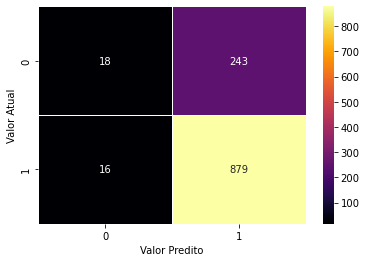

In [ ]:
rf_confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap='inferno', linewidths=.5)
plt.show()

## C2: CNN

Tensorflow Addons: https://github.com/tensorflow/addons

In [ ]:
#!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D #Embedding, Input

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow Adons Version: ", tfa.__version__)

Tensorflow Version:  2.6.0
GPUs Available:  1
Tensorflow Adons Version:  0.16.1


In [ ]:
seed = 1275
# Divisao da base de dados em treinamento, validacao e teste
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(X_train_cnn, y_train_cnn, test_size = 0.2, stratify=y_train_cnn, random_state=seed)

print('Shape do Conjunto de Treino: ', X_train_cnn.shape)
print('Shape das labels de Treino: ', y_train_cnn.shape)
print('Shape do Conjunto de Validação: ', X_valid_cnn.shape)
print('Shape das labels de Validação: ', y_valid_cnn.shape)
print('Shape do Conjunto de Teste: ', X_test_cnn.shape)
print('Shape das labels de Teste: ', y_test_cnn.shape)

Shape do Conjunto de Treino:  (4160, 118, 100)
Shape das labels de Treino:  (4160,)
Shape do Conjunto de Validação:  (1041, 118, 100)
Shape das labels de Validação:  (1041,)
Shape do Conjunto de Teste:  (578, 118, 100)
Shape das labels de Teste:  (578,)


In [ ]:
INPUT_SHAPE = (max_len, VECTOR_SIZE,)

# Hiperparameters
FILTERS_LAYER_1=32
KERNEL_SIZE=3
HIDDEN_LAYER_1_NODES=20 #100
HIDDEN_LAYER_2_NODES=10 #50
DROPOUT_PROB=0.30

model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(FILTERS_LAYER_1, KERNEL_SIZE, strides= 1, padding="same", activation='relu', input_shape=INPUT_SHAPE),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(HIDDEN_LAYER_1_NODES, activation='relu'),
    keras.layers.Dropout(DROPOUT_PROB),
    keras.layers.Dense(HIDDEN_LAYER_2_NODES, activation='relu'),
    keras.layers.Dropout(DROPOUT_PROB),
    keras.layers.Dense(1, activation='sigmoid')
])

# Obs.: A última camada utiliza função de ativação sigmoid por se tratar de uma 
# classificação binária: a avaliação é positiva ou negativa

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 118, 32)           9632      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
from tensorflow_addons.metrics.f_scores import F1Score
# F1Score = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics= F1Score(num_classes=2, average="micro", threshold=0.6))

In [ ]:
BATCH_SIZE = 25    # Tamanho do batch de treinamento
N_EPOCHS = 100

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
# This callback will stop the training when there is no improvement in the loss for five consecutive epochs.

history_cnn = model_cnn.fit(
                            x=X_train_cnn, 
                            y=y_train_cnn, 
                            epochs=N_EPOCHS, 
                            batch_size=BATCH_SIZE, 
                            verbose='auto', 
                            validation_data=(X_valid_cnn,y_valid_cnn),
                            callbacks=[callback],
                          )
print('\nQuantidade de épocas executadas: ', len(history_cnn.history['val_loss']))

Epoch 1/100
167/167 [==============================] - 10s 8ms/step - loss: 0.5589 - f1_score: 0.7620 - val_loss: 0.4606 - val_f1_score: 0.8804
Epoch 2/100
167/167 [==============================] - 1s 6ms/step - loss: 0.4693 - f1_score: 0.8545 - val_loss: 0.4103 - val_f1_score: 0.8902
Epoch 3/100
167/167 [==============================] - 1s 6ms/step - loss: 0.4229 - f1_score: 0.8790 - val_loss: 0.3841 - val_f1_score: 0.8749
Epoch 4/100
167/167 [==============================] - 1s 6ms/step - loss: 0.3953 - f1_score: 0.8889 - val_loss: 0.3549 - val_f1_score: 0.8986
Epoch 5/100
167/167 [==============================] - 1s 6ms/step - loss: 0.3602 - f1_score: 0.9027 - val_loss: 0.3634 - val_f1_score: 0.9069
Epoch 6/100
167/167 [==============================] - 1s 6ms/step - loss: 0.3383 - f1_score: 0.9070 - val_loss: 0.3378 - val_f1_score: 0.9062
Epoch 7/100
167/167 [==============================] - 1s 6ms/step - loss: 0.3090 - f1_score: 0.9203 - val_loss: 0.3346 - val_f1_score: 0.903

In [ ]:
valid_loss_cnn, valid_f1_score_cnn = model_cnn.evaluate(X_valid_cnn, y_valid_cnn, verbose = 'auto')

print('Valid Loss:', valid_loss_cnn)
print('Valid F1 Score:', valid_f1_score_cnn)

Valid Loss: 0.48324155807495117
Valid F1 Score: 0.9100784659385681


In [ ]:
test_loss_cnn, test_f1_score_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose = 'auto')

print('Test Loss:', test_loss_cnn)
print('Test F1 Score:', test_f1_score_cnn)

Test Loss: 0.5061014294624329
Test F1 Score: 0.9193899631500244


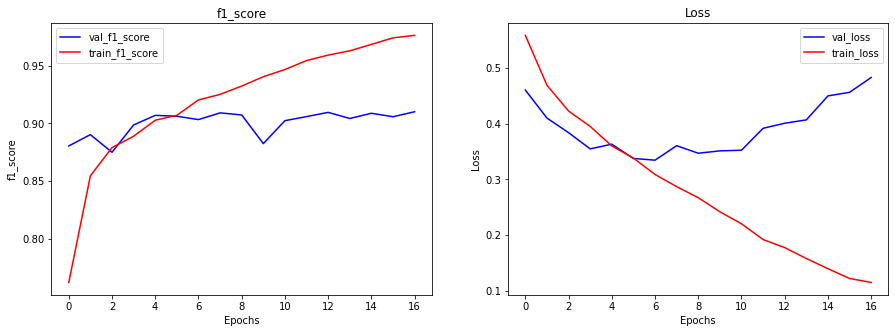

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['val_f1_score'], color='blue', label='val_f1_score')
plt.plot(history_cnn.history['f1_score'], color='red', label='train_f1_score')
plt.title('f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
#plt.ylim(None, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['val_loss'], color='blue', label='val_loss')
plt.plot(history_cnn.history['loss'], color='red', label='train_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, None);
plt.legend();

In [ ]:
y_predicted_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype('int8')
print(np.reshape(y_predicted_cnn, len(y_predicted_cnn)))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1
 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 

In [ ]:
print("\nClasification report:\n", classification_report(y_test_cnn, y_predicted_cnn))
print("Confusion matrix:\n", confusion_matrix(y_test_cnn, y_predicted_cnn))


Clasification report:
               precision    recall  f1-score   support

           0       0.76      0.60      0.67       131
           1       0.89      0.95      0.92       447

    accuracy                           0.87       578
   macro avg       0.83      0.77      0.79       578
weighted avg       0.86      0.87      0.86       578

Confusion matrix:
 [[ 78  53]
 [ 24 423]]


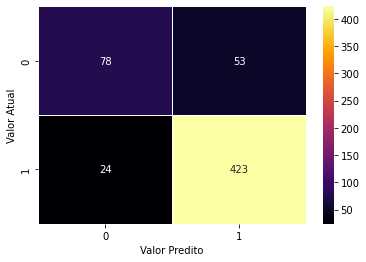

In [ ]:
cnn_confusion_matrix = pd.crosstab(np.reshape(y_test_cnn, len(y_test_cnn)), np.reshape(y_predicted_cnn, len(y_predicted_cnn)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(cnn_confusion_matrix, annot=True, fmt="d", cmap='inferno', linewidths=.5)
plt.show()

### Ajuste dos Hiperparâmetros com keras tuner - CNN

In [ ]:
#!pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

In [ ]:
from tensorflow_addons.metrics.f_scores import F1Score
METRICS_F1 = F1Score(num_classes=2, average="micro", threshold=0.6)

def model_cnn_builder(hp):
  # Hiperparameters
  KERNEL_SIZE=3
  DROPOUT_PROB=0.30
  INPUT_SHAPE = (max_len, VECTOR_SIZE,)

  HP_FILTERS_LAYER_1 = hp.Int('filters_1', min_value=16, max_value=256, step=16)
  HP_HIDDEN_LAYER_1_UNITS = hp.Int('units_1', min_value=10, max_value=100, step=10)
  HP_HIDDEN_LAYER_2_UNITS = hp.Int('units_2', min_value=10, max_value=50, step=10)

  model_cnn_tn = keras.models.Sequential([
      keras.layers.Conv1D(filters=HP_FILTERS_LAYER_1, kernel_size=KERNEL_SIZE, strides= 1, padding="same", activation='relu', input_shape=INPUT_SHAPE),
      keras.layers.GlobalMaxPooling1D(),
      keras.layers.Dense(units=HP_HIDDEN_LAYER_1_UNITS, activation='relu'),
      keras.layers.Dropout(DROPOUT_PROB),
      keras.layers.Dense(units=HP_HIDDEN_LAYER_2_UNITS, activation='relu'),
      keras.layers.Dropout(DROPOUT_PROB),
      keras.layers.Dense(1, activation='sigmoid')
  ])
    
  #from tensorflow_addons.metrics.f_scores import F1Score

  HP_LEARNING_RATE = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

  model_cnn_tn.compile(
      loss="binary_crossentropy", 
      optimizer=keras.optimizers.Adam(learning_rate=HP_LEARNING_RATE), 
      metrics=METRICS_F1
  )

  return model_cnn_tn

In [ ]:
MAX_EPOCHS = 150

tuner_cnn = kt.Hyperband(
                          model_cnn_builder,
                          objective= kt.Objective('val_loss', direction='min'), #("val_f1_score", direction="max"),
                          max_epochs=MAX_EPOCHS,
                          factor=3,
                          directory='cnn_stem_tuner_dir_1',
                          project_name='cnn_stem_tuner_val_loss_1'
                        )
#tuner_cnn.search_space_summary()

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

BATCH_SIZE = 25    # Tamanho do batch de treinamento
N_EPOCHS = 100

tuner_cnn.search(
                  x=X_train_cnn, 
                  y=y_train_cnn, 
                  epochs=N_EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  #verbose='auto', 
                  validation_data=(X_valid_cnn,y_valid_cnn),
                  callbacks=[stop_early],
                )

Trial 254 Complete [00h 00m 27s]
val_loss: 0.3447176218032837

Best val_loss So Far: 0.3111410140991211
Total elapsed time: 00h 58m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

for h_param in ['units_1', 'units_2'] + ['learning_rate'] + ['filters_1']:
  print(h_param, best_hps.get(h_param))

units_1 60
units_2 40
learning_rate 0.001
filters_1 208


In [ ]:
# Encontre o número ótimo de épocas para treinar o modelo com os hiperparâmetros obtidos na busca

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_cnn_tn = tuner_cnn.hypermodel.build(best_hps)

history_cnn_tn = model_cnn_tn.fit(
                                    x=X_train_cnn, 
                                    y=y_train_cnn, 
                                    epochs=N_EPOCHS, 
                                    batch_size=BATCH_SIZE, 
                                    verbose='auto',
                                    validation_data=(X_valid_cnn,y_valid_cnn)
                                  )

val_loss_per_epoch = history_cnn_tn.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
167/167 [==============================] - 9s 51ms/step - loss: 0.5021 - f1_score: 0.8672 - val_loss: 0.4064 - val_f1_score: 0.8950
Epoch 2/100
167/167 [==============================] - 1s 7ms/step - loss: 0.4016 - f1_score: 0.8874 - val_loss: 0.3634 - val_f1_score: 0.8905
Epoch 3/100
167/167 [==============================] - 1s 7ms/step - loss: 0.3429 - f1_score: 0.9078 - val_loss: 0.3884 - val_f1_score: 0.9071
Epoch 4/100
167/167 [==============================] - 1s 7ms/step - loss: 0.2968 - f1_score: 0.9238 - val_loss: 0.3226 - val_f1_score: 0.9123
Epoch 5/100
167/167 [==============================] - 1s 8ms/step - loss: 0.2455 - f1_score: 0.9374 - val_loss: 0.3280 - val_f1_score: 0.9075
Epoch 6/100
167/167 [==============================] - 1s 7ms/step - loss: 0.2043 - f1_score: 0.9517 - val_loss: 0.3633 - val_f1_score: 0.8938
Epoch 7/100
167/167 [==============================] - 1s 7ms/step - loss: 0.1600 - f1_score: 0.9633 - val_loss: 0.4221 - val_f1_score: 0.916

Epoch 58/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0314 - f1_score: 0.9941 - val_loss: 0.8502 - val_f1_score: 0.9094
Epoch 59/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0178 - f1_score: 0.9964 - val_loss: 0.8745 - val_f1_score: 0.9067
Epoch 60/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0201 - f1_score: 0.9960 - val_loss: 1.2750 - val_f1_score: 0.8747
Epoch 61/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0406 - f1_score: 0.9916 - val_loss: 0.8463 - val_f1_score: 0.9064
Epoch 62/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0215 - f1_score: 0.9966 - val_loss: 0.9090 - val_f1_score: 0.9086
Epoch 63/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0202 - f1_score: 0.9963 - val_loss: 0.8210 - val_f1_score: 0.9068
Epoch 64/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0173 - f1_score: 0.9971 - val_loss: 0.9659 - val_f1_score:

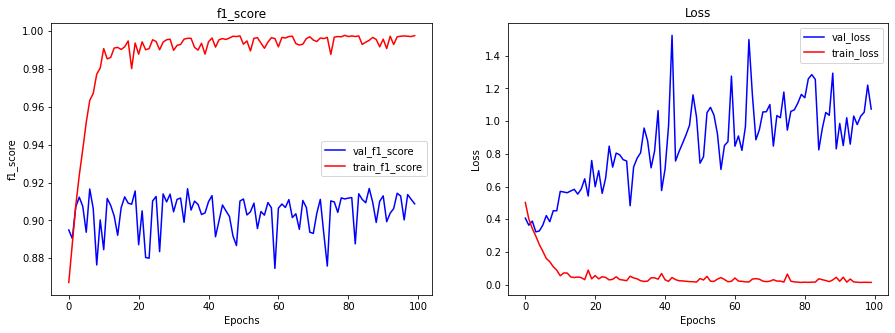

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_tn.history['val_f1_score'], color='blue', label='val_f1_score')
plt.plot(history_cnn_tn.history['f1_score'], color='red', label='train_f1_score')
plt.title('f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
#plt.ylim(None, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cnn_tn.history['val_loss'], color='blue', label='val_loss')
plt.plot(history_cnn_tn.history['loss'], color='red', label='train_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, None);
plt.legend();

In [ ]:
hypermodel_cnn = tuner_cnn.hypermodel.build(best_hps)

# Retrain the model
hypermodel_cnn.fit(
                    x=X_train_cnn, 
                    y=y_train_cnn,  
                    epochs=best_epoch,
                    batch_size=BATCH_SIZE, 
                    verbose='auto',
                    validation_data=(X_valid_cnn,y_valid_cnn)
                  )

Epoch 1/4
167/167 [==============================] - 2s 10ms/step - loss: 0.5062 - f1_score: 0.8670 - val_loss: 0.4184 - val_f1_score: 0.8913
Epoch 2/4
167/167 [==============================] - 1s 7ms/step - loss: 0.4023 - f1_score: 0.8847 - val_loss: 0.3955 - val_f1_score: 0.9016
Epoch 3/4
167/167 [==============================] - 1s 7ms/step - loss: 0.3502 - f1_score: 0.9031 - val_loss: 0.3468 - val_f1_score: 0.8877
Epoch 4/4
167/167 [==============================] - 1s 7ms/step - loss: 0.2990 - f1_score: 0.9211 - val_loss: 0.3260 - val_f1_score: 0.9112


In [ ]:
test_loss_cnn_tn, test_f1_score_cnn_tn = hypermodel_cnn.evaluate(X_test_cnn, y_test_cnn, verbose = 'auto')

print('Test Loss:', test_loss_cnn_tn)
print('Test F1 Score:', test_f1_score_cnn_tn)

Test Loss: 0.3271526098251343
Test F1 Score: 0.9222343564033508


In [ ]:
y_predicted_hp_cnn = (hypermodel_cnn.predict(X_test_cnn) > 0.5).astype('int8')

print("\nClasification report:\n", classification_report(y_test_cnn, y_predicted_hp_cnn))
print("Confusion matrix:\n", confusion_matrix(y_test_cnn, y_predicted_hp_cnn))


Clasification report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70       131
           1       0.90      0.96      0.93       447

    accuracy                           0.88       578
   macro avg       0.85      0.79      0.81       578
weighted avg       0.88      0.88      0.87       578

Confusion matrix:
 [[ 81  50]
 [ 19 428]]


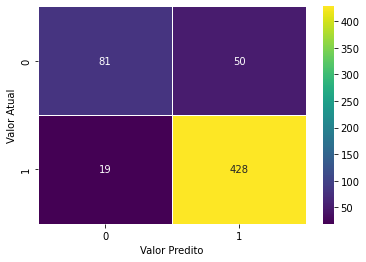

In [ ]:
cnn_confusion_matrix = pd.crosstab(np.reshape(y_test_cnn, len(y_test_cnn)), np.reshape(y_predicted_hp_cnn, len(y_predicted_hp_cnn)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(cnn_confusion_matrix, annot=True, fmt="d", cmap='viridis', linewidths=.5)
plt.show()

## C3: LSTM

In [ ]:
# Normalização [-1,1] para entrada na LSTM com função de ativação 'tanh'
# X_min = X.min()
# X_max = X.max()
# range = X_max - X_min

# X_norm = ((X - X_min)/range - 0.5) * 2

# print('Range após normalização:', [X_norm.min(), X_norm.max()])

In [ ]:
#y_lstm = pd.get_dummies(df_reviews['sentiment']).values # one-hot-encoding

In [ ]:
seed = 1275
# Divisao da base de dados em treinamento, validacao e teste
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_train_lstm, X_valid_lstm, y_train_lstm, y_valid_lstm = train_test_split(X_train_lstm, y_train_lstm, test_size = 0.2, stratify=y_train_lstm, random_state=seed)

print('Shape do Conjunto de Treino: ', X_train_lstm.shape)
print('Shape das labels de Treino: ', y_train_lstm.shape)
print('Shape do Conjunto de Validação: ', X_valid_lstm.shape)
print('Shape das labels de Validação: ', y_valid_lstm.shape)
print('Shape do Conjunto de Teste: ', X_test_lstm.shape)
print('Shape das labels de Teste: ', y_test_lstm.shape)

Shape do Conjunto de Treino:  (4160, 118, 100)
Shape das labels de Treino:  (4160,)
Shape do Conjunto de Validação:  (1041, 118, 100)
Shape das labels de Validação:  (1041,)
Shape do Conjunto de Teste:  (578, 118, 100)
Shape das labels de Teste:  (578,)


In [ ]:
#vocab_size = len(model_amazon.wv.vocab)
#embedding_dim = 10

INPUT_SHAPE = (max_len,VECTOR_SIZE,)

model_lstm = Sequential([ 
                         keras.layers.LSTM(32, input_shape=INPUT_SHAPE, activation='tanh'),
                         keras.layers.Dropout(0.3),   # Regularizador
                         keras.layers.Dense(20, activation='relu'),
                         keras.layers.Dropout(0.3),   # Regularizador
                         keras.layers.Dense(10, activation='relu'),
                         keras.layers.Dropout(0.3),   # Regularizador
                         keras.layers.Dense(1, activation='sigmoid')
                        ])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [ ]:
from tensorflow_addons.metrics.f_scores import F1Score

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics= F1Score(num_classes=2, average="micro", threshold=0.6))

In [ ]:
batch_size = 25    # Tamanho do batch de treinamento
n_epochs = 100

In [ ]:
callback_lstm = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
# This callback will stop the training when there is no improvement inthe loss for five consecutive epochs.

history_lstm = model_lstm.fit(
                          x=X_train_lstm, 
                          y=y_train_lstm, 
                          epochs=n_epochs, 
                          batch_size=batch_size, 
                          verbose='auto', 
                          validation_data=(X_valid_lstm,y_valid_lstm),
                          callbacks=[callback_lstm],
                        )
print('\nQuantidade de épocas executadas: ', len(history_lstm.history['val_f1_score']))

Epoch 1/100
167/167 [==============================] - 5s 14ms/step - loss: 0.5689 - f1_score: 0.7774 - val_loss: 0.5291 - val_f1_score: 0.8728
Epoch 2/100
167/167 [==============================] - 2s 10ms/step - loss: 0.5404 - f1_score: 0.8369 - val_loss: 0.4768 - val_f1_score: 0.8755
Epoch 3/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4966 - f1_score: 0.8372 - val_loss: 0.4503 - val_f1_score: 0.8611
Epoch 4/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4652 - f1_score: 0.8483 - val_loss: 0.4191 - val_f1_score: 0.8776
Epoch 5/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4542 - f1_score: 0.8490 - val_loss: 0.4041 - val_f1_score: 0.8896
Epoch 6/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4280 - f1_score: 0.8611 - val_loss: 0.4058 - val_f1_score: 0.8939
Epoch 7/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4369 - f1_score: 0.8629 - val_loss: 0.3923 - val_f1_score:

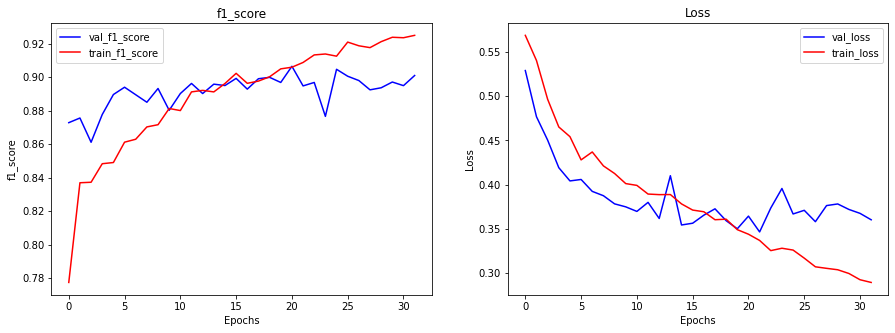

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['val_f1_score'], color='blue', label='val_f1_score')
plt.plot(history_lstm.history['f1_score'], color='red', label='train_f1_score')
plt.title('f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
#plt.ylim(None, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['val_loss'], color='blue', label='val_loss')
plt.plot(history_lstm.history['loss'], color='red', label='train_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, None);
plt.legend();

In [ ]:
test_loss_lstm, test_f1_score_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose = 'auto')

print('Test Loss:', test_loss_lstm)
print('Test F1 Score:', test_f1_score_lstm)

Test Loss: 0.3438500463962555
Test F1 Score: 0.9082968831062317


In [ ]:
y_predicted_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype('int8')
print(np.reshape(y_predicted_lstm, len(y_predicted_lstm)))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1
 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 

In [ ]:
print("\nClasification report:\n", classification_report(y_test_lstm, y_predicted_lstm))
print("Confusion matrix:\n", confusion_matrix(y_test_lstm, y_predicted_lstm))


Clasification report:
               precision    recall  f1-score   support

           0       0.80      0.53      0.64       131
           1       0.88      0.96      0.92       447

    accuracy                           0.86       578
   macro avg       0.84      0.75      0.78       578
weighted avg       0.86      0.86      0.85       578

Confusion matrix:
 [[ 70  61]
 [ 18 429]]


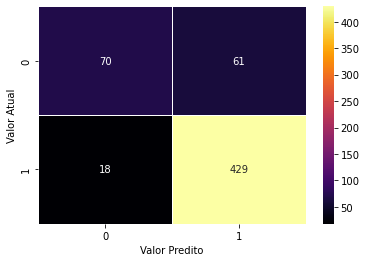

In [ ]:
lstm_confusion_matrix = pd.crosstab(np.reshape(y_test_lstm, len(y_test_lstm)), np.reshape(y_predicted_lstm, len(y_predicted_lstm)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(lstm_confusion_matrix, annot=True, fmt="d", cmap='inferno', linewidths=.5)
plt.show()

### Ajuste dos Hiperparâmetros com keras tuner - LSTM

In [ ]:
from tensorflow_addons.metrics.f_scores import F1Score
METRICS_F1 = F1Score(num_classes=2, average="micro", threshold=0.6)

def model_lstm_builder(hp):
  # Hiperparameters
  #KERNEL_SIZE=3
  DROPOUT_PROB=0.30
  INPUT_SHAPE = (max_len, VECTOR_SIZE,)

  HP_LSTM_UNITS = hp.Int('units_1', min_value=16, max_value=256, step=16)
  HP_HIDDEN_LAYER_1_UNITS = hp.Int('units_2', min_value=10, max_value=100, step=10)
  HP_HIDDEN_LAYER_2_UNITS = hp.Int('units_3', min_value=10, max_value=50, step=10)

  INPUT_SHAPE = (max_len,VECTOR_SIZE,)

  model_lstm_tn = Sequential([ 
                         keras.layers.LSTM(32, input_shape=INPUT_SHAPE, activation='tanh'),
                         keras.layers.Dropout(DROPOUT_PROB),   # Regularizador
                         keras.layers.Dense(20, activation='relu'),
                         keras.layers.Dropout(DROPOUT_PROB),   # Regularizador
                         keras.layers.Dense(10, activation='relu'),
                         keras.layers.Dropout(DROPOUT_PROB),   # Regularizador
                         keras.layers.Dense(1, activation='sigmoid')
                        ])

  HP_LEARNING_RATE = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

  model_lstm_tn.compile(
      loss="binary_crossentropy", 
      optimizer=keras.optimizers.Adam(learning_rate=HP_LEARNING_RATE), 
      metrics=METRICS_F1
  )

  return model_lstm_tn

In [ ]:
MAX_EPOCHS = 150

tuner_lstm = kt.Hyperband(
                          model_lstm_builder,
                          objective= kt.Objective("val_loss", direction="min"),
                          max_epochs=MAX_EPOCHS,
                          factor=3,
                          directory='lstm_stem_tuner_dir_1',
                          project_name='lstm_stem_tuner_2'
                        )
#tuner_cnn.search_space_summary()

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=10)

BATCH_SIZE = 25    # Tamanho do batch de treinamento
N_EPOCHS = 100

tuner_lstm.search(
                  x=X_train_lstm, 
                  y=y_train_lstm, 
                  epochs=N_EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  #verbose='auto', 
                  validation_data=(X_valid_lstm,y_valid_lstm),
                  callbacks=[stop_early],
                )

Trial 254 Complete [00h 00m 20s]
val_loss: 0.5922866463661194

Best val_loss So Far: 0.3405005633831024
Total elapsed time: 01h 01m 06s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps_lstm=tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

for h_param in ['units_1', 'units_2', 'units_3'] + ['learning_rate']:
  print(h_param, best_hps_lstm.get(h_param))

units_1 112
units_2 50
units_3 20
learning_rate 0.01


In [ ]:
# Encontre o número ótimo de épocas para treinar o modelo com os hiperparâmetros obtidos na busca

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_lstm_tn = tuner_lstm.hypermodel.build(best_hps_lstm)

history_lstm_tn = model_lstm_tn.fit(
                                    x=X_train_lstm, 
                                    y=y_train_lstm, 
                                    epochs=N_EPOCHS, 
                                    batch_size=BATCH_SIZE, 
                                    verbose='auto',
                                    validation_data=(X_valid_lstm,y_valid_lstm)
                                  )

val_loss_per_epoch = history_lstm_tn.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
167/167 [==============================] - 4s 14ms/step - loss: 0.5491 - f1_score: 0.8462 - val_loss: 0.4993 - val_f1_score: 0.8728
Epoch 2/100
167/167 [==============================] - 2s 9ms/step - loss: 0.4868 - f1_score: 0.8651 - val_loss: 0.4716 - val_f1_score: 0.8570
Epoch 3/100
167/167 [==============================] - 1s 9ms/step - loss: 0.4591 - f1_score: 0.8665 - val_loss: 0.4249 - val_f1_score: 0.8896
Epoch 4/100
167/167 [==============================] - 2s 9ms/step - loss: 0.4334 - f1_score: 0.8622 - val_loss: 0.4028 - val_f1_score: 0.8900
Epoch 5/100
167/167 [==============================] - 2s 10ms/step - loss: 0.4156 - f1_score: 0.8825 - val_loss: 0.3783 - val_f1_score: 0.8937
Epoch 6/100
167/167 [==============================] - 2s 10ms/step - loss: 0.3904 - f1_score: 0.8833 - val_loss: 0.3970 - val_f1_score: 0.8986
Epoch 7/100
167/167 [==============================] - 2s 10ms/step - loss: 0.3815 - f1_score: 0.8811 - val_loss: 0.3688 - val_f1_score: 0.

Epoch 58/100
167/167 [==============================] - 2s 9ms/step - loss: 0.2128 - f1_score: 0.9429 - val_loss: 0.5727 - val_f1_score: 0.8634
Epoch 59/100
167/167 [==============================] - 2s 9ms/step - loss: 0.2198 - f1_score: 0.9451 - val_loss: 0.6420 - val_f1_score: 0.8973
Epoch 60/100
167/167 [==============================] - 2s 9ms/step - loss: 0.1873 - f1_score: 0.9496 - val_loss: 0.6928 - val_f1_score: 0.8963
Epoch 61/100
167/167 [==============================] - 2s 9ms/step - loss: 0.1890 - f1_score: 0.9548 - val_loss: 0.6306 - val_f1_score: 0.9018
Epoch 62/100
167/167 [==============================] - 2s 9ms/step - loss: 0.1917 - f1_score: 0.9532 - val_loss: 0.7496 - val_f1_score: 0.9004
Epoch 63/100
167/167 [==============================] - 2s 9ms/step - loss: 0.1719 - f1_score: 0.9577 - val_loss: 0.6837 - val_f1_score: 0.8938
Epoch 64/100
167/167 [==============================] - 1s 9ms/step - loss: 0.1583 - f1_score: 0.9608 - val_loss: 0.6032 - val_f1_score:

In [ ]:
hypermodel_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)

# Retrain the model
hypermodel_lstm.fit(
                    x=X_train_lstm, 
                    y=y_train_lstm,  
                    epochs=best_epoch,
                    batch_size=BATCH_SIZE, 
                    verbose='auto',
                    validation_data=(X_valid_lstm,y_valid_lstm)
                  )

Epoch 1/12
167/167 [==============================] - 8s 14ms/step - loss: 0.5527 - f1_score: 0.8575 - val_loss: 0.5150 - val_f1_score: 0.8728
Epoch 2/12
167/167 [==============================] - 2s 10ms/step - loss: 0.4972 - f1_score: 0.8678 - val_loss: 0.4470 - val_f1_score: 0.8755
Epoch 3/12
167/167 [==============================] - 2s 9ms/step - loss: 0.4582 - f1_score: 0.8526 - val_loss: 0.5816 - val_f1_score: 0.8728
Epoch 4/12
167/167 [==============================] - 2s 9ms/step - loss: 0.5073 - f1_score: 0.8726 - val_loss: 0.5682 - val_f1_score: 0.8728
Epoch 5/12
167/167 [==============================] - 2s 9ms/step - loss: 0.5365 - f1_score: 0.8726 - val_loss: 0.5196 - val_f1_score: 0.8728
Epoch 6/12
167/167 [==============================] - 2s 9ms/step - loss: 0.5226 - f1_score: 0.8726 - val_loss: 0.5037 - val_f1_score: 0.8728
Epoch 7/12
167/167 [==============================] - 2s 9ms/step - loss: 0.4820 - f1_score: 0.8726 - val_loss: 0.4422 - val_f1_score: 0.8728
Epoc

In [ ]:
test_loss_lstm_tn, test_f1_score_lstm_tn = hypermodel_lstm.evaluate(X_test_lstm, y_test_lstm, verbose = 'auto')

print('Test Loss:', test_loss_lstm_tn)
print('Test F1 Score:', test_f1_score_lstm_tn)

Test Loss: 0.40266942977905273
Test F1 Score: 0.8283581733703613


In [ ]:
y_predicted_hp_lstm = (hypermodel_lstm.predict(X_test_lstm) > 0.5).astype('int8')

print("\nClasification report:\n", classification_report(y_test_lstm, y_predicted_hp_lstm))
print("Confusion matrix:\n", confusion_matrix(y_test_lstm, y_predicted_hp_lstm))


Clasification report:
               precision    recall  f1-score   support

           0       0.55      0.76      0.63       131
           1       0.92      0.82      0.86       447

    accuracy                           0.80       578
   macro avg       0.73      0.79      0.75       578
weighted avg       0.83      0.80      0.81       578

Confusion matrix:
 [[ 99  32]
 [ 82 365]]


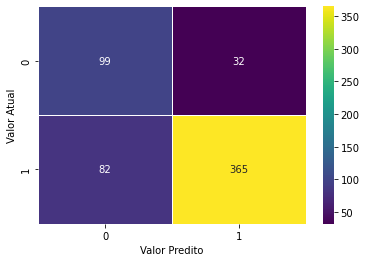

In [ ]:
lstm_confusion_matrix = pd.crosstab(np.reshape(y_test_lstm, len(y_test_lstm)), np.reshape(y_predicted_hp_lstm, len(y_predicted_hp_lstm)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(lstm_confusion_matrix, annot=True, fmt="d", cmap='viridis', linewidths=.5)
plt.show()